In [43]:
import sys
import os
sys.path.insert(0,os.path.abspath("../lib/"))

import json

from util import JSONExtendedEncoder

from modulecontainers import Modules

%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib.pyplot import *

import pandas as pd
import numpy as np

import multiprocessing as mp

from collections import OrderedDict

from itertools import product
from collections import defaultdict

import itertools
import shutil

conf_folder = "conf/"

import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This runs parameter estimation using either functional enrichment as in Figure 3 of our paper.

## Run a method

To run individual methods:

In [44]:
from modulescomparison import ModevalFunctional, ModevalKnownmodules, ModevalCoverage

In [1]:
methodname = "agglom"
settings_name = "paramexplo/" + methodname
settings = json.load(open("../conf/settings/{}.json".format(settings_name)))

NameError: name 'json' is not defined

In [46]:
# create pool of processors
if "pool" in locals().keys():
    pool.close()
pool = mp.Pool(1)

Process ForkPoolWorker-5:
Traceback (most recent call last):
  File "/home/wsaelens/miniconda3/envs/moduledetect/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/wsaelens/miniconda3/envs/moduledetect/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/wsaelens/miniconda3/envs/moduledetect/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/wsaelens/miniconda3/envs/moduledetect/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/wsaelens/projects/moduledetection-evaluation/lib/modulescomparison.py", line 397, in modenrichevalworker
    settingscores_gsets = modenrichevalscorer(modules, membership, connectivity)
  File "/home/wsaelens/projects/moduledetection-evaluation/lib/modulescomparison.py", line 476, in modenrichevalscorer
    "b

In [47]:
modeval_functional = ModevalFunctional([setting for setting in settings if not setting["dataset_name"].startswith("synth")])

In [48]:
modeval_functional.run(pool)

Evaluating a total of 1344 settings.


KeyboardInterrupt: 

In [ ]:
modeval_functional.save(settings_name)

## Combine output from different methods

Combine different methods to compare:

In [23]:
method_names = ["dummy", "agglom"]

In [27]:
scores = {}
for methodname in method_names:
    settings_name = "paramexplo/" + methodname
    settings = json.load(open("../conf/settings/{}.json".format(settings_name)))
    settings_dataset = pd.DataFrame([dict(settingid=setting["settingid"], **json.load(open("../" + setting["dataset_location"]))["params"]) for setting in settings])
    settings_method = pd.DataFrame([dict(settingid=setting["settingid"], **json.load(open("../" + setting["method_location"]))["params"]) for setting in settings])
    
    modeval_functional.load(settings_name)

    modeval_knownmodules = ModevalKnownmodules(settings)
    modeval_knownmodules.load(settings_name)
    modeval_coverage = ModevalCoverage(settings)
    modeval_coverage.load(settings_name)

    modeval_coverage.scores["refscore"] = modeval_coverage.scores["aucodds_permuted"]
    modeval_knownmodules.scores["refscore"] = modeval_knownmodules.scores["F1rprr_permuted"]
    modeval_knownmodules.scores["moduledef"] = [modulesname if modulesname in ["minimal", "strict"] else "interconnected" for modulesname in modeval_knownmodules.scores["knownmodules_name"]]

    refscores = pd.concat([modeval_knownmodules.scores, modeval_coverage.scores], ignore_index=True)[["settingid", "refscore", "goldstandard", "moduledef"]]
    refscores = refscores.merge(settings_dataset, on="settingid")
    
    proxyscores = modeval_functional.scores.rename(columns={"score":"proxyscore", "scorename":"proxyname"})
    
    combined = refscores.merge(proxyscores, on="settingid")
    
    scores[methodname] = combined

In [28]:
optimalproxy_funcs = {"asw":np.nanargmax, "ch":np.nanargmax, "dbindex":np.nanargmin, "dbstarindex":np.nanargmin, "bhi#go":np.nanargmax, "bhi#kegg":np.nanargmax, "bhi#reactome":np.nanargmax, 
                      "faucodds#go":np.nanargmax, "faucodds#kegg":np.nanargmax, "faucodds#reactome":np.nanargmax}

In [30]:
methodscores

,settingid,refscore,goldstandard,moduledef,datasetname,organism,proxyname,proxyscore
0,ecoli_colombos_0,0.999904,ecoli_regulondb#mcl2,interconnected,ecoli_colombos,ecoli,bhi#kegg,0.018868
1,ecoli_colombos_0,0.999904,ecoli_regulondb#mcl2,interconnected,ecoli_colombos,ecoli,faucodds#kegg,0.011770
2,ecoli_colombos_0,0.999904,ecoli_regulondb#mcl2,interconnected,ecoli_colombos,ecoli,bhi#go,0.062176
3,ecoli_colombos_0,0.999904,ecoli_regulondb#mcl2,interconnected,ecoli_colombos,ecoli,faucodds#go,0.010013
4,ecoli_colombos_0,0.687690,ecoli_regulondb#minimal,minimal,ecoli_colombos,ecoli,bhi#kegg,0.018868
...,...,...,...,...,...,...,...,...
1123,human_tcga_3,0.183811,regcircuit,NaN,human_tcga,human,faucodds#kegg,0.014474
1124,human_tcga_3,0.183811,regcircuit,NaN,human_tcga,human,bhi#go,0.287339
1125,human_tcga_3,0.183811,regcircuit,NaN,human_tcga,human,faucodds#go,0.001295
1126,human_tcga_3,0.183811,regcircuit,NaN,human_tcga,human,bhi#reactome,0.031348


In [32]:
finalscores = []

for method, methodscores in scores.items():
    methodscores["proxyscore"][np.isinf(methodscores["proxyscore"])] = np.nan
    for (dataset, goldstandard, proxyname), subscores in methodscores.groupby(["datasetname", "goldstandard", "proxyname"]):
        if proxyname not in optimalproxy_funcs.keys():
            continue
        if proxyname.endswith("reactome"):
            continue

        optimalproxy_func = optimalproxy_funcs[proxyname]
        if np.all(np.isnan(subscores["proxyscore"])):
            print("random?", method)
            print(dataset, refgrouper,proxygrouper)
            optimalproxy = np.random.choice(subscores.index)
        else:
            optimalproxy = subscores.index[optimalproxy_func(subscores["proxyscore"])]
            
        row = subscores.loc[optimalproxy].copy()
        row["optimalrefscore"] = subscores["refscore"].max()
        row["method"] = method
        finalscores.append(row)
finalscores = pd.DataFrame(finalscores).rename(columns={"organism":"organismoi", "goldstandard":"goldstandardoi", "refscore":"score"})

/tmp/ipykernel_91716/3358237533.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  methodscores["proxyscore"][np.isinf(methodscores["proxyscore"])] = np.nan


In [33]:
from collections import Counter

In [35]:
def add_weights(scores):
    weights = []
    scores["moduledef"] = scores["moduledef"].fillna("")
    for organismoi, subscores in scores.groupby("organismoi"):
        moduledef_weights = 1/subscores.groupby("moduledef")["score"].count()
        for moduledef, weight in moduledef_weights.items():
            weights.append({
                    "organism":organismoi,
                    "moduledef":moduledef,
                    "weight":weight / len(moduledef_weights)
                })
    weights = pd.DataFrame(weights).set_index(["organism", "moduledef"])["weight"]
    
    scores["weight"] = weights.loc[pd.Index(scores[["organismoi", "moduledef"]])].tolist()
    
    return scores

In [37]:
proxyscores_ = add_weights(finalscores)
proxyscores = proxyscores_.groupby(["proxyname", "method"]).apply(lambda x: np.average(x.score, weights=x.weight)).unstack()

proxyscores_.groupby("method").apply(lambda x: np.average(x.optimalrefscore, weights=x.weight))

method
agglom    6.246780
dummy     0.671632
dtype: float64

In [40]:
testscores_original = pd.read_table("../results/testscores_.tsv", index_col=0)
testscores_original = testscores_original.query("organismoi != 'synth'").groupby("method").apply(lambda x: np.average(x.score, weights=x.weight))

trainingscores_original = pd.read_table("../results/trainingscores_.tsv", index_col=0)
trainingscores_original = trainingscores_original.query("organismoi != 'synth'").groupby("method").apply(lambda x: np.average(x.score, weights=x.weight))

proxyscores.loc["training"] = trainingscores_original.loc[proxyscores.columns]
proxyscores.loc["test"] = testscores_original.loc[proxyscores.columns]

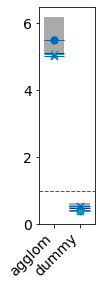

In [42]:
xs = pd.Series(np.arange(0, len(proxyscores.columns)), index=proxyscores.columns)
fig = figure(figsize=(len(xs)*0.5,4))
ax = fig.add_subplot(111)

markersettings = {
    "training":["#999999", "_", 0],
    "test":["#333333", "_", 0],
    "bhi#go":["#00A6BF", "o", 50],
    "faucodds#go":["#0067bd", "o", 50],
    "bhi#kegg":["#00A6BF", "x", 50],
    "faucodds#kegg":["#0067bd", "x", 50]
}

proxyorder = ["test", "bhi#go", "faucodds#go", "bhi#kegg", "faucodds#kegg", "training"]
proxyscores = proxyscores.loc[proxyorder]
w = 0.8
for method, methodscores in proxyscores.iteritems():
    x = xs[method]
    ax.add_patch(
        Rectangle(
            (x-w/2, methodscores["test"]),
            w,
            methodscores["training"]-methodscores["test"],
            fc="#AAAAAA", zorder=0, lw=0
        )
    )
    for i, (proxygroup, score) in enumerate(methodscores.items()):
        if proxygroup in ["training"]:#, "test"]:
            ""
        else:
            markersetting = markersettings[proxygroup]
            scatter(x, score, color=markersetting[0], marker=markersetting[1], s=markersetting[2], zorder=i+5)
            #scatter(x, score, color=markersetting[0], marker="_", s=250)
            line =  Line2D((x-w/2,x+w/2),(score, score),color=markersetting[0], zorder=i+5, solid_capstyle="butt", lw=1)
            ax.add_artist(line)
        
ax.set_ylim(0, 6.5)
ax.set_xlim(-.6, xs.max()+0.6)
#axis("off")
ax.set_xticks(range(len(proxyscores.columns)))
ax.set_xticklabels(proxyscores.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(0, 6.01, 2))

axhline(1, linestyle="--", color="#555555", lw=1)

ax.tick_params(labelsize=14)